In [291]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [292]:
import pandas as pd

df = pd.read_csv('NFLX.csv')
df = df[['Close']].dropna()

close_real_prices = df.values
print(df)

           Close
0     254.259995
1     265.720001
2     264.559998
3     250.100006
4     249.470001
...          ...
1004  427.140015
1005  457.130005
1006  429.480011
1007  405.600006
1008  410.170013

[1009 rows x 1 columns]


In [293]:


def window_df(df, n):
    windowed_df = pd.DataFrame()
    for i in range(n, 0, -1):
        windowed_df[f'Target-{i}'] = df['Close'].shift(i)
    windowed_df['Target'] = df['Close']
    return windowed_df.dropna()

window = 125
df_window = window_df(df, window)

C:\Users\mikol\AppData\Local\Temp\ipykernel_29300\4200158628.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  windowed_df[f'Target-{i}'] = df['Close'].shift(i)
C:\Users\mikol\AppData\Local\Temp\ipykernel_29300\4200158628.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  windowed_df[f'Target-{i}'] = df['Close'].shift(i)
C:\Users\mikol\AppData\Local\Temp\ipykernel_29300\4200158628.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

In [294]:

# load the dataset

dataset = df.values
dataset = dataset.astype('float32')

In [295]:

# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

In [296]:
# split into train and test sets
train_size = int(len(dataset) * 0.79)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

797 212


In [297]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [298]:

# reshape into X=t and Y=t+1
look_back = window
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(testX.shape)

(86, 125)


In [299]:

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
print((trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print((trainX.shape[0], 1, trainX.shape[1]))

trainX.shape

(671, 1, 1)
(671, 1, 1)


(671, 1, 125)

In [300]:
for i in trainY:
    print(i)

-0.5229026
-0.48869622
-0.48472083
-0.5031564
-0.4955114
-0.5107578
-0.53067875
-0.54736686
-0.59581494
-0.6131147
-0.6378411
-0.59000456
-0.5450516
-0.51700497
-0.5400275
-0.45418406
-0.42902088
-0.4119395
-0.41390538
-0.40106153
-0.4154781
-0.43330204
-0.53124666
-0.5081804
-0.498482
-0.49966145
-0.4668095
-0.4055612
-0.41342485
-0.42910826
-0.49118638
-0.41560912
-0.41862357
-0.4256134
-0.4438305
-0.40704668
-0.40783298
-0.37091815
-0.35855496
-0.3873005
-0.3554095
-0.37415087
-0.37454414
-0.43308365
-0.48681772
-0.49664712
-0.46777058
-0.59804285
-0.6189686
-0.5383239
-0.566414
-0.5084424
-0.42849648
-0.5070882
-0.5684236
-0.5820974
-0.566283
-0.70315206
-0.6549225
-0.7118894
-0.777375
-0.77313745
-0.70337045
-0.63521993
-0.6713921
-0.643695
-0.6637907
-0.5910094
-0.6328608
-0.69598746
-0.73705256
-0.73561096
-0.7691182
-0.7545707
-0.77138996
-0.8395841
-0.85539854
-0.87658644
-0.8910465
-0.8796445
-0.85692763
-0.78694224
-0.7602936
-0.77173936
-0.7535223
-0.8189206
-0.7859374
-0.8

In [301]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

# model = Sequential([layers.Input((trainX.shape[1], window)),                  
#                     layers.LSTM(64),                        
#                     layers.Dense(32),
#                     layers.Dense(32, activation='relu'),
#                     layers.Dense(1)])

model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(trainX.shape[1], window)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(20))
model.add(Dense(20))
model.add(Dense(1))

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])
model.fit(trainX, trainY, epochs = 500,batch_size=16,callbacks=[callback])

Epoch 1/500
42/42 [==============================] - 3s 4ms/step - loss: 0.0681 - mean_absolute_error: 0.2108
Epoch 2/500
42/42 [==============================] - 0s 3ms/step - loss: 0.0141 - mean_absolute_error: 0.0953
Epoch 3/500
42/42 [==============================] - 0s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0764
Epoch 4/500
42/42 [==============================] - 0s 3ms/step - loss: 0.0075 - mean_absolute_error: 0.0675
Epoch 5/500
42/42 [==============================] - 0s 3ms/step - loss: 0.0066 - mean_absolute_error: 0.0625
Epoch 6/500
42/42 [==============================] - 0s 3ms/step - loss: 0.0055 - mean_absolute_error: 0.0561
Epoch 7/500
42/42 [==============================] - 0s 3ms/step - loss: 0.0047 - mean_absolute_error: 0.0519
Epoch 8/500
42/42 [==============================] - 0s 3ms/step - loss: 0.0046 - mean_absolute_error: 0.0515
Epoch 9/500
42/42 [==============================] - 0s 3ms/step - loss: 0.0039 - mean_absolute_error: 0.0473
Epoch 10/5

In [302]:
# model = Sequential()
# model.add(LSTM(32, return_sequences=True,
#                input_shape=( trainX.shape[1],window)))  # returns a sequence of vectors of dimension 32
# model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
# model.add(LSTM(32))  # return a single vector of dimension 32
# model.add(Dense(10, activation='softmax'))

# model.compile(loss='mse', 
#               optimizer=Adam(learning_rate=0.001),
#               metrics=['mean_absolute_error'])
# model.fit(trainX, trainY, epochs = 500,batch_size=16,callbacks=[callback])

21/21 [==============================] - 1s 2ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


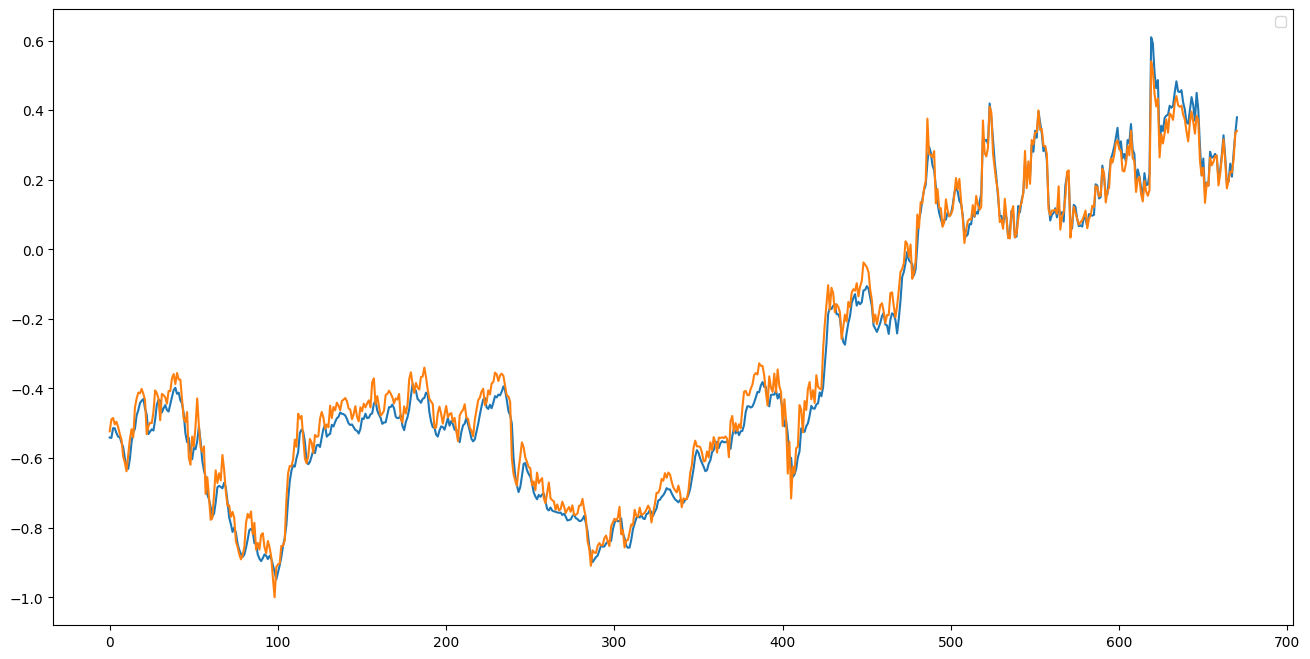

In [303]:
predicted_train = model.predict(trainX)


plt.figure(figsize=(16,8))
plt.plot(predicted_train[:,-1].reshape(-1))

plt.legend()
plt.plot(trainY)

3/3 [==============================] - 0s 3ms/step
[0.2913088  0.27381733 0.28850535 0.25654373 0.21708299 0.25930604
 0.272423   0.25079137 0.26003322 0.23411877 0.20453636 0.21908696
 0.22470886 0.20677298 0.23307723 0.24621122 0.25590482 0.2663481
 0.2561585  0.24523623 0.22124998 0.21951339 0.22047995 0.19880828
 0.19088204 0.19825612 0.2038062  0.19569589 0.20088853 0.20062561
 0.17852984 0.15770464 0.14636949 0.13440914 0.13137756 0.12911813
 0.11906141 0.11671712 0.10291111 0.11365007 0.11634149 0.10826595
 0.11326067 0.12928553 0.13692193 0.1599439  0.17206982 0.16442667
 0.16006476 0.16681515 0.1647558  0.18649626 0.23781744 0.25303397
 0.25087848 0.2707215  0.288161   0.27698764 0.2599471  0.24915738
 0.24564816 0.23322429 0.23486932 0.24136586 0.2613282  0.26502505
 0.25076887 0.23654297 0.24368475 0.27129793 0.2602668  0.26479542
 0.27547708 0.24585126 0.24543922 0.2586781  0.25015852 0.22483791
 0.21802689 0.2102407  0.22810966 0.32098952 0.31961903 0.329905
 0.37051085 0.

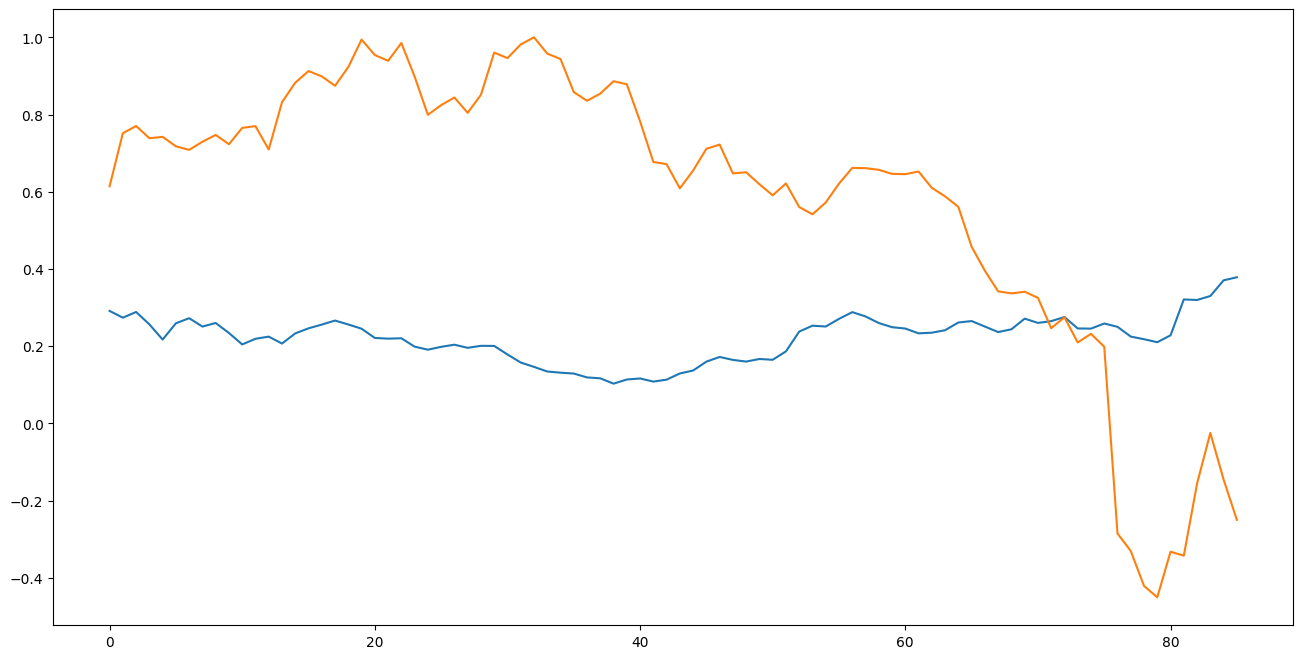

In [304]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

predicted = model.predict(testX)

print(predicted[:,0])

plt.figure(figsize=(16,8))
plt.plot(predicted[:,0].reshape(-1))

plt.plot(testY)


# rms =  math.sqrt(mean_squared_error(real_prices,predicted_prices))
# print(rms)

In [305]:
r2_train = r2_score(testY, predicted[:,0].reshape(-1))
print("Test data R2 score:", r2_train)

Test data R2 score: -1.150069830243416


In [306]:
import statistics
testX.shape
predictions = []
latest_prices = trainX

general_prediction = model.predict(latest_prices)[-1]

x,y,z = latest_prices.shape
for i in range(len(test)):
    
    prediction = model.predict(latest_prices)[-1][0]
    predictions.append(prediction)
    print(prediction)
    temp_array = latest_prices[1:,:,:]
    last_row = temp_array[-1,:,:]
    temp_row = np.zeros(last_row.shape)
    

    
    for i in range(z-1):
        temp_row[0][i] = last_row[0][i+1]
    
    temp_row[0][-1] = prediction
    # print(temp_row)
    # temp_row_reshaped = temp_row.reshape(1, temp_row.shape[0], 1)
    latest_prices = np.concatenate([latest_prices, temp_row[np.newaxis, :, :]], axis=0)
    # print(temp_row[0,-3:])

    

21/21 [==============================] - 0s 2ms/step
0.37934923
21/21 [==============================] - 0s 2ms/step
0.36838523
22/22 [==============================] - 0s 2ms/step
0.41107574
22/22 [==============================] - 0s 2ms/step
0.36616015
22/22 [==============================] - 0s 2ms/step
0.28881153
22/22 [==============================] - 0s 2ms/step
0.2414109
22/22 [==============================] - 0s 2ms/step
0.24275
22/22 [==============================] - 0s 2ms/step
0.22338907
22/22 [==============================] - 0s 1ms/step
0.25641862
22/22 [==============================] - 0s 2ms/step
0.25119242
22/22 [==============================] - 0s 1ms/step
0.19984445
22/22 [==============================] - 0s 2ms/step
0.16707347
22/22 [==============================] - 0s 2ms/step
0.18804872
22/22 [==============================] - 0s 2ms/step
0.23772174
22/22 [==============================] - 0s 2ms/step
0.2618434
22/22 [==============================] - 0s 2

In [307]:
print((((np.array(predictions)).reshape(-1))).reshape(-1, 1))
predicted_prices = scaler.inverse_transform((((np.array(predictions)).reshape(-1))).reshape(-1, 1))
real_prices = scaler.inverse_transform(test.reshape(-1, 1))
sequence_prediction = scaler.inverse_transform(general_prediction.reshape(-1, 1))

print(real_prices.shape)
print(testY.shape)
print(test.shape)

[[0.37934923]
 [0.36838523]
 [0.41107574]
 [0.36616015]
 [0.28881153]
 [0.2414109 ]
 [0.24275   ]
 [0.22338907]
 [0.25641862]
 [0.25119242]
 [0.19984445]
 [0.16707347]
 [0.18804872]
 [0.23772174]
 [0.2618434 ]
 [0.22625773]
 [0.22583549]
 [0.19423127]
 [0.11728673]
 [0.10941927]
 [0.11562999]
 [0.10235965]
 [0.12607852]
 [0.20276012]
 [0.23806165]
 [0.26493105]
 [0.2530654 ]
 [0.25431484]
 [0.18341935]
 [0.16209243]
 [0.15849902]
 [0.20805328]
 [0.22958632]
 [0.27286813]
 [0.2994003 ]
 [0.42328748]
 [0.36053154]
 [0.3999849 ]
 [0.40746248]
 [0.44133404]
 [0.4183648 ]
 [0.43641254]
 [0.44461012]
 [0.4791718 ]
 [0.42872894]
 [0.448083  ]
 [0.4123039 ]
 [0.44234762]
 [0.49748203]
 [0.55784184]
 [0.53677547]
 [0.5735408 ]
 [0.4922391 ]
 [0.4632096 ]
 [0.39749047]
 [0.4866372 ]
 [0.4558405 ]
 [0.41101897]
 [0.46307132]
 [0.62276775]
 [0.5239676 ]
 [0.4339076 ]
 [0.3849357 ]
 [0.38939676]
 [0.41543218]
 [0.4242952 ]
 [0.52443635]
 [0.5790047 ]
 [0.49782225]
 [0.4684986 ]
 [0.49947128]
 [0.45

Test data R2 score: 0.09694543980837389


Text(0.5, 1.0, 'R2 = 0.09694543980837389')

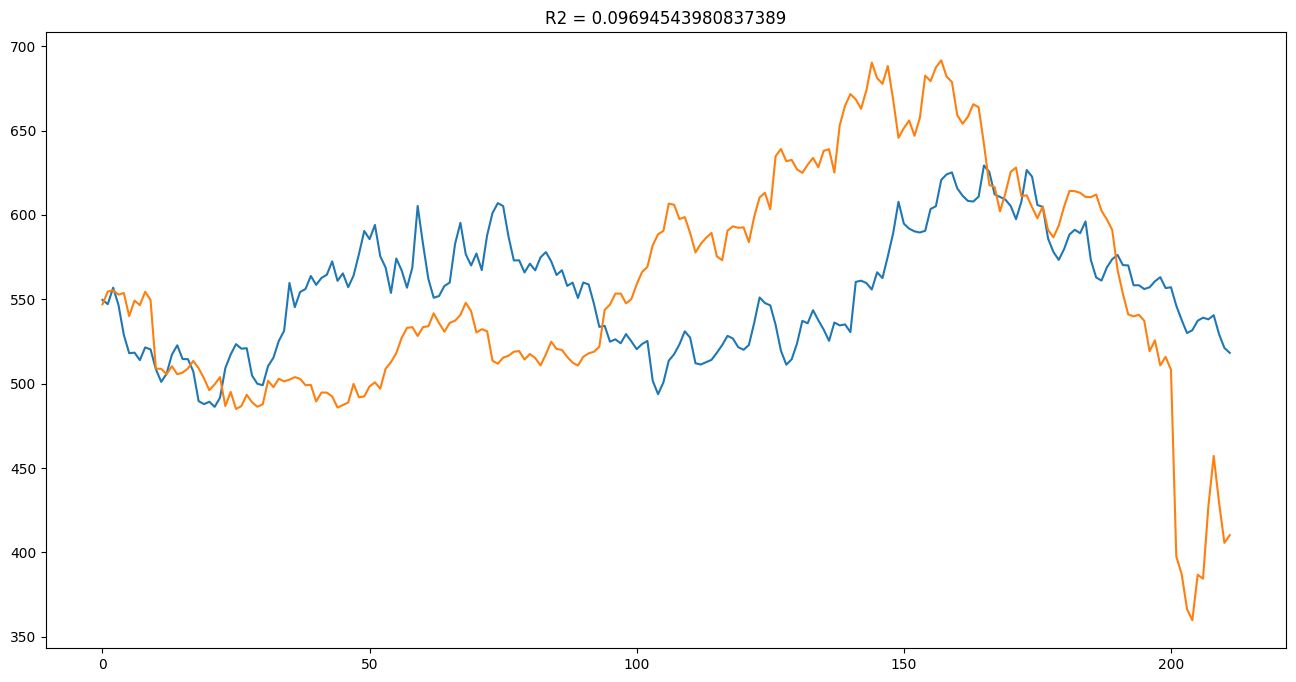

In [308]:
r2_test = r2_score(real_prices, predicted_prices)
print("Test data R2 score:", r2_test)



plt.figure(figsize=(16,8))
# plt.plot(sequence_prediction)
plt.plot(predicted_prices)
plt.plot(real_prices)
title = "R2 = "+str(r2_test)
plt.title(title)

Text(0.5, 1.0, 'R2 =  0.385027161277647')

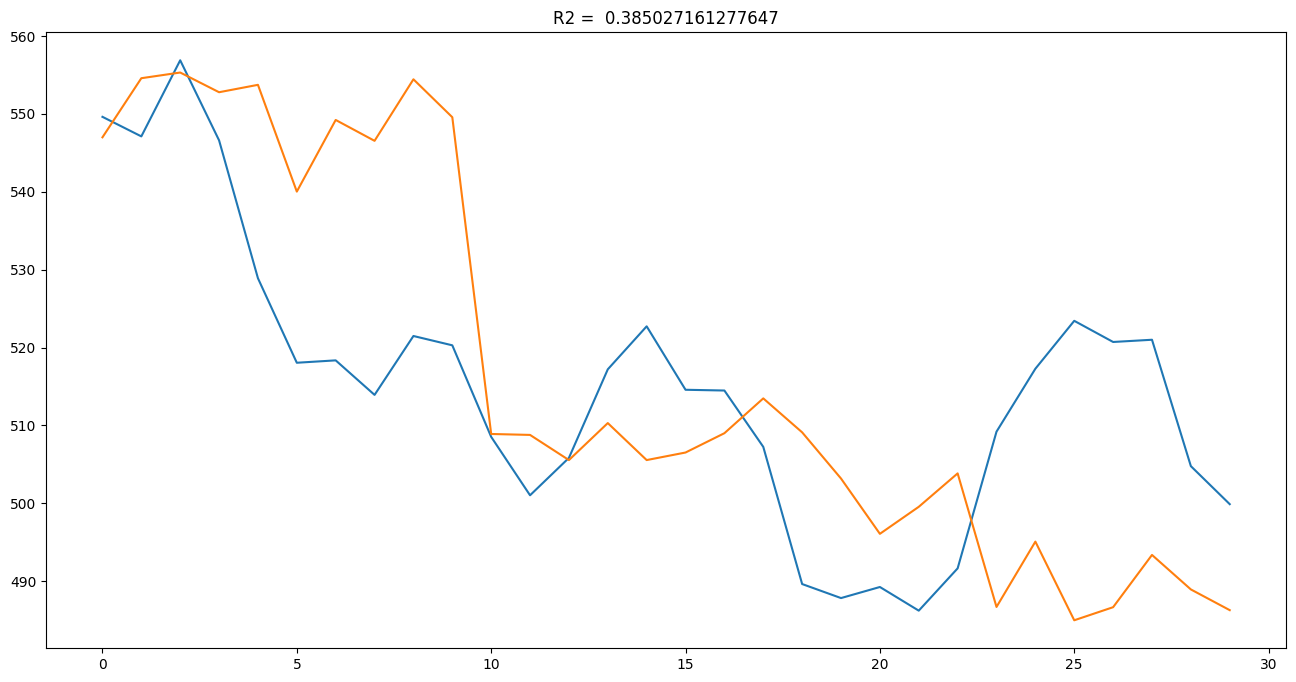

In [309]:
plt.figure(figsize=(16,8))
# plt.plot(sequence_prediction)
plt.plot(predicted_prices[:30])
plt.plot(real_prices[:30])

r2_test_first = r2_score(real_prices[:30], predicted_prices[:30])
title = "R2 =  "+str(r2_test_first)
plt.title(title)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1008, 1)


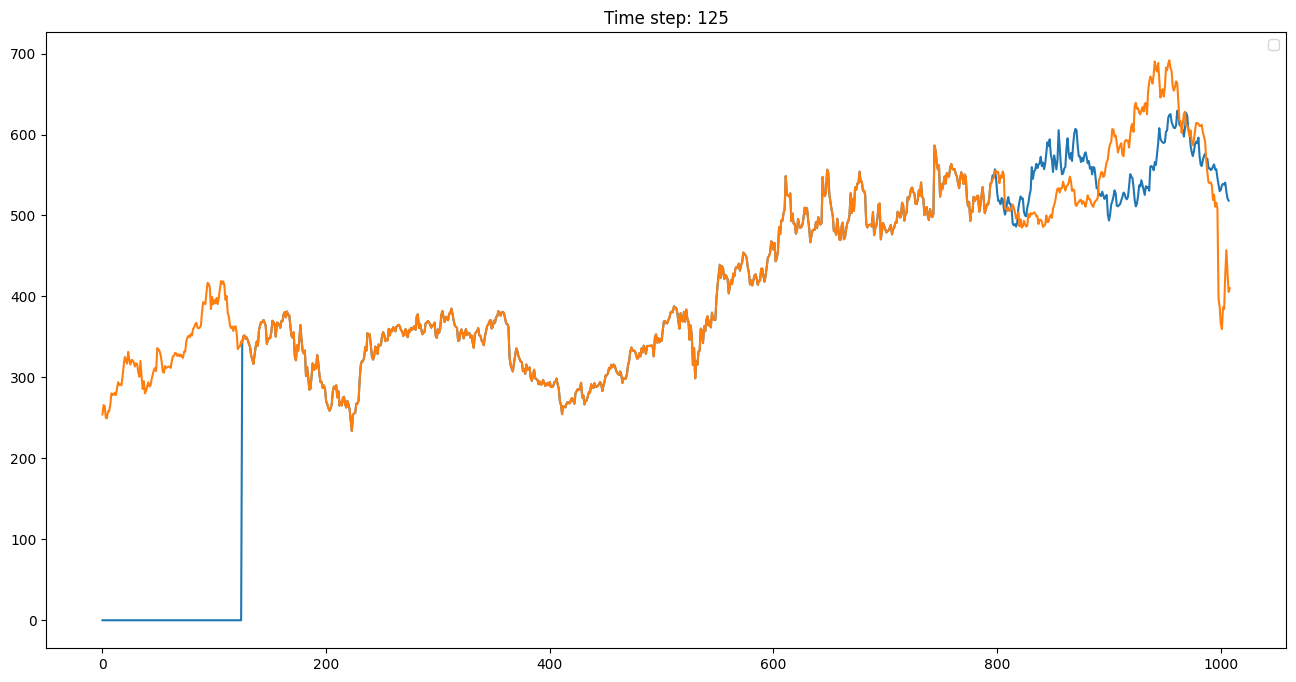

In [310]:
plt.figure(figsize = (16,8))
empty_array = np.zeros((window,1))

previous_prices = scaler.inverse_transform(trainY.reshape(-1, 1))
previous_prices_vstacked = np.vstack((empty_array,previous_prices,predicted_prices))


print(previous_prices_vstacked.shape)

plt.plot(previous_prices_vstacked)
plt.plot(close_real_prices)

title = "Time step: "+str(window)
plt.title(title)
plt.legend()
plt.show()